In [1]:
import json
import warnings
warnings.filterwarnings("ignore")

# File paths
file1 = "renttherunway_final_data.json"

# Function to read JSON lines data from a file
def read_json_lines(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))  # Load each JSON object per line
    return data

# Load data from each file
renttherunway_data = read_json_lines(file1)

# Display the data (printing just the first entry for readability)
print("Rent the Runway Data Sample:", renttherunway_data[0])

Rent the Runway Data Sample: {'fit': 'fit', 'user_id': '420272', 'bust size': '34d', 'item_id': '2260466', 'weight': '137lbs', 'rating': '10', 'rented for': 'vacation', 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.", 'body type': 'hourglass', 'review_summary': 'So many compliments!', 'category': 'romper', 'height': '5\' 8"', 'size': 14, 'age': '28', 'review_date': 'April 20, 2016'}


In [2]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
from sklearn import linear_model
import tensorflow as tf
from sklearn.metrics import fbeta_score, accuracy_score

2024-12-02 16:08:13.442713: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 16:08:13.564658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import pandas as pd

renttherunway_df = pd.read_json(file1, lines=True)
renttherunway_df.describe()


,user_id,item_id,rating,size,age
count,192544.000000,1.925440e+05,192462.000000,192544.000000,191584.000000
mean,499494.100149,1.045684e+06,9.092371,12.245175,33.871017
std,289059.719328,8.053148e+05,1.430044,8.494877,8.058083
min,9.000000,1.233730e+05,2.000000,0.000000,0.000000
25%,250654.250000,1.950760e+05,8.000000,8.000000,29.000000
50%,499419.000000,9.483960e+05,10.000000,12.000000,32.000000
75%,750974.000000,1.678888e+06,10.000000,16.000000,37.000000
max,999997.000000,2.966087e+06,10.000000,58.000000,117.000000


In [4]:
# Remove rows with any null values
cleaned_renttherunway_df = renttherunway_df.dropna()

# Display null values after cleaning to verify
cleaned_null_values = cleaned_renttherunway_df.isnull().sum()
print(f"\nNull values in Renttherunway dataset after cleaning:\n{cleaned_null_values}")

# Summary of cleaned dataset
cleaned_summary = cleaned_renttherunway_df.describe()
cleaned_summary


Null values in Renttherunway dataset after cleaning:
fit               0
user_id           0
bust size         0
item_id           0
weight            0
rating            0
rented for        0
review_text       0
body type         0
review_summary    0
category          0
height            0
size              0
age               0
review_date       0
dtype: int64


,user_id,item_id,rating,size,age
count,146381.000000,1.463810e+05,146381.000000,146381.000000,146381.000000
mean,498991.574528,1.052277e+06,9.081985,11.437919,34.089800
std,289658.524623,8.091076e+05,1.437853,7.826784,8.113217
min,9.000000,1.233730e+05,2.000000,0.000000,0.000000
25%,249294.000000,1.956130e+05,8.000000,4.000000,29.000000
50%,499034.000000,9.618190e+05,10.000000,9.000000,32.000000
75%,750840.000000,1.687082e+06,10.000000,16.000000,37.000000
max,999997.000000,2.966087e+06,10.000000,58.000000,117.000000


In [5]:
##### Transform the nan-numerical features to the numerical label.

import re
def preprocess_data(df):
    # Convert bust size (e.g., '34D') into numerical features
    def parse_bust_size(bust):
        if isinstance(bust, str) and re.match(r'^\d+[A-Z]$', bust.upper()):  # Validate format like '34D'
            bust = bust.upper()  # Normalize to uppercase
            band, cup = int(bust[:-1]), bust[-1]
            cup_size = ord(cup) - ord('A') + 1  # A=1, B=2, C=3, ...
            return band, cup_size
        return None, None

    df['band_size'], df['cup_size'] = zip(*df['bust size'].apply(parse_bust_size))

    # Convert weight (e.g., '137lbs') to numerical
    df['weight_numeric'] = df['weight'].str.extract(r'(\d+)').astype(float)  # Extract numeric part

    # Convert height (e.g., '5\' 8"') to inches
    def height_to_inches(height):
        if isinstance(height, str) and re.match(r'^\d+\' \d+"$', height):
            height = height.replace('"', '').replace("'", "")  # Remove double quotes and apostrophe
            feet, inches = map(int, height.split())
            return feet * 12 + inches
        return None

    df['height_inches'] = df['height'].apply(height_to_inches)

    # Encode body type
    body_type_mapping = {v: i for i, v in enumerate(df['body type'].dropna().unique())}
    df['body_type_encoded'] = df['body type'].map(body_type_mapping)

    # Encode rented for
    rented_for_mapping = {v: i for i, v in enumerate(df['rented for'].dropna().unique())}
    df['rented_for_encoded'] = df['rented for'].map(rented_for_mapping)

    # Drop or fill missing values
    df = df.dropna(subset=['band_size', 'cup_size', 'weight_numeric', 'height_inches', 
                           'body_type_encoded', 'rented_for_encoded', 'fit'])

    return df

# Apply preprocessing to the dataset
cleaned_df = preprocess_data(cleaned_renttherunway_df)

# Check the updated dataset
print(cleaned_df.head())


   fit  user_id bust size  item_id  weight  rating     rented for  \
0  fit   420272       34d  2260466  137lbs    10.0       vacation   
1  fit   273551       34b   153475  132lbs    10.0          other   
3  fit   909926       34c   126335  135lbs     8.0  formal affair   
4  fit   151944       34b   616682  145lbs    10.0        wedding   
5  fit   734848       32b   364092  138lbs     8.0           date   

                                         review_text          body type  \
0  An adorable romper! Belt and zipper were a lit...          hourglass   
1  I rented this dress for a photo shoot. The the...  straight & narrow   
3  I rented this for my company's black tie award...               pear   
4  I have always been petite in my upper body and...           athletic   
5  Didn't actually wear it. It fit perfectly. The...           athletic   

                                     review_summary  ... height size   age  \
0                              So many compliments!  ...

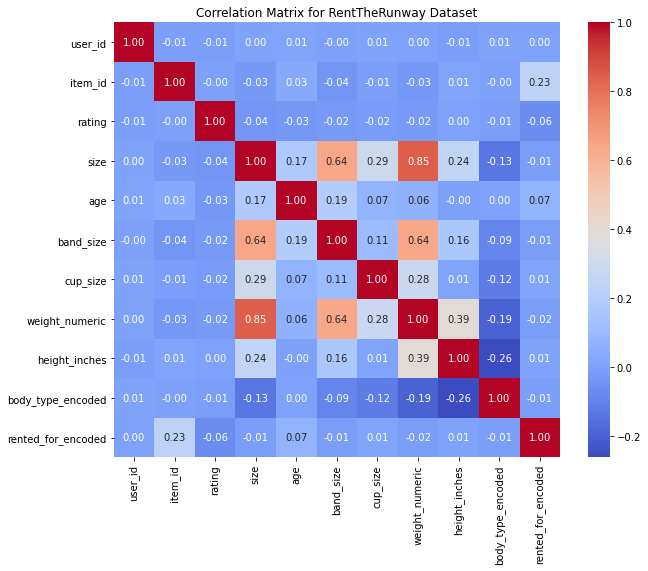

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix for numerical fields in RentTheRunway dataset
renttherunway_corr = cleaned_renttherunway_df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(renttherunway_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix for RentTheRunway Dataset")
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

# Set a random seed for reproducibility
random_seed = 42

# Divide the cleaned dataset into train, validate, and test datasets
train_df, temp_df = train_test_split(cleaned_df, test_size=0.3, random_state=random_seed)  # 70% train
validate_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=random_seed)  # 15% validate, 15% test

# Display the shapes of the resulting datasets
print(f"Train dataset shape: {train_df.shape}")
print(f"Validate dataset shape: {validate_df.shape}")
print(f"Test dataset shape: {test_df.shape}")


Train dataset shape: (94848, 21)
Validate dataset shape: (20325, 21)
Test dataset shape: (20325, 21)


In [8]:
## Methond 1.1. 
#  Just randomly guess the labels and test the f2 score on the test dataset.

import numpy as np
from sklearn.metrics import fbeta_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Ensure 'fit' column is encoded for classification tasks
label_encoder = LabelEncoder()
train_df['fit_encoded'] = label_encoder.fit_transform(train_df['fit'])
validate_df['fit_encoded'] = label_encoder.transform(validate_df['fit'])
test_df['fit_encoded'] = label_encoder.transform(test_df['fit'])

test_y = test_df['fit_encoded']
# Generate random predictions with the same class distribution as the test set
unique_classes = np.unique(test_y)
random_predictions = np.random.choice(unique_classes, size=len(test_y))

# Compute the F2 score for the random predictions
f2_score_random = fbeta_score(test_y, random_predictions, beta=2, average='weighted')

print(f"Baseline F2 Score (Random Guessing): {f2_score_random:.4f}")

Baseline F2 Score (Random Guessing): 0.3381


In [9]:
## method 9.1 Single Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import fbeta_score

# Define the features and target variable
features = ['weight_numeric', 'height_inches', 'band_size', 'cup_size', 'body_type_encoded', 'size']
target = 'fit_encoded'

# Prepare training and testing data
train_X = train_df[features]
train_y = train_df[target]
test_X = test_df[features]
test_y = test_df[target]

# Initialize and train the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)  # Limit depth to avoid overfitting
dt_model.fit(train_X, train_y)

# Make predictions on the test set
test_predictions = dt_model.predict(test_X)

# Compute the F2 score
f2_score_dt = fbeta_score(test_y, test_predictions, beta=2, average='weighted')

print(f"F2 Score for Decision Tree Model: {f2_score_dt:.4f}")


F2 Score for Decision Tree Model: 0.6877


In [10]:
train_df['weight_size_interaction'] = train_df['weight_numeric'] * train_df['size']
test_df['weight_size_interaction'] = test_df['weight_numeric'] * test_df['size']

In [11]:
#Mehtod 10: CatBoostClassifer
import catboost
from catboost import CatBoostClassifier
from sklearn.metrics import fbeta_score

# Define the features and target variable
features = ['weight_numeric', 'size', 'weight_size_interaction']
target = 'fit_encoded'

# Prepare training and testing data
train_X = train_df[features]
train_y = train_df[target]
test_X = test_df[features]
test_y = test_df[target]

# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, verbose=0)

# Fit the model
catboost_model.fit(train_X, train_y)

# Make predictions on the test set
catboost_predictions = catboost_model.predict(test_X)

accuracy_catboost= accuracy_score(test_y, catboost_predictions)

# Compute the F2 score
f2_score_catboost = fbeta_score(test_y, catboost_predictions, beta=2, average='weighted')

print(f"F2 Score for CatBoost Model: {f2_score_catboost:.4f}")
print(f"F2 Score for CatBoost Model: {accuracy_catboost:.4f}")


F2 Score for CatBoost Model: 0.6860
F2 Score for CatBoost Model: 0.7352


In [12]:
#Method 11: MLP
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import fbeta_score

# Initialize MLPClassifier (Multi-layer Perceptron)
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, learning_rate='adaptive', random_state=42)

# Fit the model
mlp_model.fit(train_X, train_y)

# Make predictions on the test set
mlp_predictions = mlp_model.predict(test_X)

# Compute the F2 score
f2_score_mlp = fbeta_score(test_y, mlp_predictions, beta=2, average='weighted')
accuracy_mlp=accuracy_score(test_y, mlp_predictions)

print(f"F2 Score for MLP Model: {f2_score_mlp:.4f}")
print(f"F2 Score for MLP Model: {accuracy_mlp:.4f}")


F2 Score for MLP Model: 0.6857
F2 Score for MLP Model: 0.7351


In [13]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [14]:
# Mehtod 12: Ensemble Learning
import xgboost as xgb
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import fbeta_score

# Define base models
base_learners = [
    ('xgb', xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.05, max_depth=6, n_estimators=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000))
]

# Define meta model
meta_model = LogisticRegression()

# Initialize StackingClassifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model)

# Fit the model
stacking_model.fit(train_X, train_y)

# Make predictions on the test set
stacking_predictions = stacking_model.predict(test_X)

accuracy_en = accuracy_score(test_y, stacking_predictions)

# Compute the F2 score
f2_score_stacking = fbeta_score(test_y, stacking_predictions, beta=2, average='weighted')

print(f"F2 Score for Stacking Model: {f2_score_stacking:.4f}")

print(f"Accuracy for Stacking Model: {accuracy_en:.4f}")


F2 Score for Stacking Model: 0.6858
Accuracy for Stacking Model: 0.7346


In [15]:
# Install pytorch-tabnet
!pip install pytorch-tabnet

from pytorch_tabnet.tab_model import TabNetClassifier


# Initialize TabNet model
tabnet_model = TabNetClassifier()

# Fit the model
tabnet_model.fit(train_X.values, train_y.values, max_epochs=5, batch_size=1024, virtual_batch_size=128)

# Make predictions on the test set
tabnet_predictions = tabnet_model.predict(test_X.values)

# Compute the F2 score
f2_score_tabnet = fbeta_score(test_y, tabnet_predictions, beta=2, average='weighted')

# Compute the accuracy score
accuracy_tabnet = accuracy_score(test_y, tabnet_predictions)

# Print the results
print(f"F2 Score for TabNet Model: {f2_score_tabnet:.4f}")
print(f"Accuracy for TabNet Model: {accuracy_tabnet:.4f}")


Defaulting to user installation because normal site-packages is not writeable
epoch 0  | loss: 0.7835  |  0:00:05s
epoch 1  | loss: 0.73697 |  0:00:10s
epoch 2  | loss: 0.73533 |  0:00:15s
epoch 3  | loss: 0.7347  |  0:00:20s
epoch 4  | loss: 0.73464 |  0:00:25s
F2 Score for TabNet Model: 0.6855
Accuracy for TabNet Model: 0.7348


In [16]:
#Mehtod 14: Deep Forest
!pip install deep-forest

from deepforest import CascadeForestClassifier
from sklearn.metrics import fbeta_score

# Initialize Deep Forest Model
deep_forest_model = CascadeForestClassifier()

# Fit the model
deep_forest_model.fit(train_X, train_y)

# Make predictions on the test set
deep_forest_predictions = deep_forest_model.predict(test_X)

# Compute the F2 score
f2_score_deep_forest = fbeta_score(test_y, deep_forest_predictions, beta=2, average='weighted')
accuracy_deep=accuracy_score(test_y, deep_forest_predictions)

print(f"F2 Score for Deep Forest Model: {f2_score_deep_forest:.4f}")
print(f"Accuracy for Deep Forest Model: {accuracy_deep:.4f}")


Defaulting to user installation because normal site-packages is not writeable
[2024-12-02 16:11:06.861] Start to fit the model:
[2024-12-02 16:11:06.861] Fitting cascade layer = 0 
[2024-12-02 16:11:16.244] layer = 0  | Val Acc = 73.359 % | Elapsed = 9.383 s
[2024-12-02 16:11:16.457] Fitting cascade layer = 1 
[2024-12-02 16:11:52.250] layer = 1  | Val Acc = 83.807 % | Elapsed = 35.793 s
[2024-12-02 16:11:52.441] Fitting cascade layer = 2 
[2024-12-02 16:12:29.503] layer = 2  | Val Acc = 84.394 % | Elapsed = 37.062 s
[2024-12-02 16:12:29.656] Fitting cascade layer = 3 
[2024-12-02 16:13:04.919] layer = 3  | Val Acc = 84.183 % | Elapsed = 35.263 s
[2024-12-02 16:13:04.919] Early stopping counter: 1 out of 2
[2024-12-02 16:13:05.099] Fitting cascade layer = 4 
[2024-12-02 16:13:40.108] layer = 4  | Val Acc = 83.955 % | Elapsed = 35.009 s
[2024-12-02 16:13:40.108] Early stopping counter: 2 out of 2
[2024-12-02 16:13:40.108] Handling early stopping
[2024-12-02 16:13:40.113] The optimal num